In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pmdarima as pm
from pmdarima.arima import auto_arima
import re
from statsmodels.tsa.stattools import adfuller


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220526','20220825','20221124','20230223','20230525']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[3]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']
symbols = symbols[symbols['Ticker_Symbol']!='TW/.L']
symbols = symbols[symbols['Ticker_Symbol']!='MDC.L']
symbols = symbols[symbols['Ticker_Symbol']!='HL/.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0     BDEV.L
1      EDV.L
3     ABDN.L
4     BLND.L
6     JMAT.L
7      HSX.L
8      UTG.L
9     FRAS.L
10     CCL.L
11    INVP.L
12     ICP.L
13     IMI.L
14    HWDN.L
15     HIK.L
16    INCH.L
18     EZJ.L
19     DPH.L
20     ITV.L
21    DPLM.L
22     IGG.L
23     SXS.L
24    TATE.L
25     EMG.L
26     TUI.L
27     GAW.L
28     MKS.L
29     DLN.L
30     RSW.L
31    BBOX.L
32     ROR.L
33     GRG.L
34     VTY.L
Name: Ticker_Symbol, dtype: object

In [5]:
symbols_ = symbols.set_index("Ticker_Symbol")

In [6]:
data = price_volume_data(symbols_short.to_list(),'2018-02-24', '2023-02-28')
data.pv

{'BDEV.L':                                  Open        High         Low       Close  \
 Date                                                                        
 2018-02-26 00:00:00+00:00  389.930223  393.187930  388.088942  390.355164   
 2018-02-27 00:00:00+00:00  396.587164  402.535988  386.814131  388.088867   
 2018-02-28 00:00:00+00:00  383.414795  387.947193  379.448898  381.715118   
 2018-03-01 00:00:00+00:00  380.157155  384.123053  372.933594  374.633270   
 2018-03-02 00:00:00+00:00  373.075270  380.723729  373.075270  377.041168   
 ...                               ...         ...         ...         ...   
 2023-02-21 00:00:00+00:00  435.043672  435.377879  419.818077  421.210663   
 2023-02-22 00:00:00+00:00  420.375110  425.295595  417.116479  422.881775   
 2023-02-23 00:00:00+00:00  422.139057  427.338019  421.860523  424.367188   
 2023-02-24 00:00:00+00:00  427.152370  428.916306  420.282288  420.282288   
 2023-02-27 00:00:00+00:00  424.274350  430.680237  42

In [7]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [8]:
df

Ticker_Symbol,BDEV.L,EDV.L,ABDN.L,BLND.L,JMAT.L,HSX.L,UTG.L,FRAS.L,CCL.L,INVP.L,...,EMG.L,TUI.L,GAW.L,MKS.L,DLN.L,RSW.L,BBOX.L,ROR.L,GRG.L,VTY.L
2018-02-26,390.355164,1963.698853,269.223969,500.147949,2659.636475,1178.911499,668.820984,374.100006,4399.957520,348.866547,...,130.073883,13795.461914,1982.502197,253.773514,2476.174561,4550.828125,109.802338,255.824783,1110.544189,766.246704
2018-02-27,388.088867,1963.698853,271.400940,490.148254,2662.166992,1196.159668,655.681946,370.200012,4392.668457,352.184875,...,131.784424,14007.421875,1990.762085,253.520020,2525.545166,4571.361816,108.958275,257.919556,1093.615234,765.533569
2018-02-28,381.715118,1963.698853,267.119476,483.071442,2645.291504,1199.609375,645.509766,367.399994,4372.624023,351.189423,...,125.015045,13930.754883,1974.241699,249.801712,2445.531006,4511.628906,107.807327,257.483124,1011.509277,749.131775
2018-03-01,374.633270,1963.698853,264.942474,482.302063,2606.476562,1198.746826,647.628845,363.399994,4320.687012,349.309021,...,119.373886,13754.873047,1945.329834,245.998871,2470.216309,4425.766113,107.577133,255.562881,1007.277039,761.967896
2018-03-02,377.041168,1963.698853,265.740723,482.763672,2556.693359,1190.122681,648.900513,356.600006,4210.437988,339.243408,...,117.554169,13691.735352,1895.767212,242.280533,2468.514404,4293.235352,107.116737,250.587814,1028.438477,772.308167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,421.210663,1692.330444,193.502747,424.567688,2096.798096,1097.981567,935.380066,804.000000,824.200012,509.219421,...,240.065155,1722.000000,8950.903320,152.550003,2489.256348,3862.539551,144.186630,316.037628,2650.445068,756.376709
2023-02-22,422.881775,1662.790771,192.393311,422.151520,2114.247070,1091.161743,932.484131,794.500000,821.400024,509.989197,...,235.914734,1668.000000,8912.091797,150.500000,2458.381592,3800.786621,142.742828,316.428772,2642.620605,748.683167
2023-02-23,424.367188,1648.153564,194.057449,424.084473,2101.645020,1088.726196,936.345398,784.500000,810.400024,515.955139,...,236.858017,1633.000000,8965.458984,152.750000,2473.818848,3872.499756,145.245392,320.340118,2628.928467,765.993713
2023-02-24,420.282288,1654.984253,195.074432,422.538147,2084.195801,1097.494385,935.862732,795.000000,789.000000,498.634735,...,230.915344,1542.599976,8907.241211,152.899994,2471.889160,3958.156738,143.897858,319.753418,2609.368164,770.321411


In [9]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file = file.set_index("Unnamed: 0")

In [10]:
file

,Actual Price,Predicted Price,MSE,MAE,R2,Market Share,final_marketcap
Unnamed: 0,,,,,,,
CCL.L,1011.500000,[1102.1017],0.004354,0.065982,1,146260000,"147,941,990,000.00"
PNN.L,921.890503,[978.6994],0.094318,0.307112,1,261327008,240914886834.23047
IGG.L,652.198731,[628.6662],0.035130,0.187431,1,395398016,257878084065.0625
ITV.L,65.962585,[66.964294],0.002242,0.047346,1,4034409984,266120113306.78125
INVP.L,433.472778,[401.9024],0.167294,0.409016,1,645161984,"279,660,157,671.13"
EMG.L,240.397629,[223.5084],0.285668,0.534479,1,1199859968,288443491180.2617
TATE.L,722.515076,[747.0776],0.113386,0.336728,1,401665984,290209728829.28516
RSW.L,4005.439697,[3899.5273],0.019304,0.138940,1,72788496,291549931382.66016
IDS.L,313.700653,[276.65097],0.108747,0.329769,1,956193024,299958376095.6797


In [11]:
########################################

In [12]:
df_standardised = df.iloc[:-3].apply(lambda price: (price.iloc[:-3] - price.iloc[:-3].mean())/price.iloc[:-3].std())
df_standardised

Ticker_Symbol,BDEV.L,EDV.L,ABDN.L,BLND.L,JMAT.L,HSX.L,UTG.L,FRAS.L,CCL.L,INVP.L,...,EMG.L,TUI.L,GAW.L,MKS.L,DLN.L,RSW.L,BBOX.L,ROR.L,GRG.L,VTY.L
2018-02-26,-0.835665,-0.153827,1.833505,0.954710,0.574013,0.429745,-1.780583,-0.532703,1.612508,0.674717,...,-0.448666,1.841920,-1.521170,1.362499,-0.996378,0.276750,-0.990435,-0.789432,-1.227494,-0.340595
2018-02-27,-0.861221,-0.153827,1.895037,0.792775,0.579877,0.493696,-1.876213,-0.553471,1.607087,0.708330,...,-0.409427,1.891545,-1.518163,1.357939,-0.859794,0.303022,-1.014129,-0.731761,-1.257666,-0.344724
2018-02-28,-0.933094,-0.153827,1.774022,0.678174,0.540776,0.506486,-1.950249,-0.568380,1.592182,0.698246,...,-0.564711,1.873595,-1.524177,1.291051,-1.081153,0.226596,-1.046438,-0.743776,-1.404001,-0.439697
2018-03-01,-1.012952,-0.153827,1.712490,0.665715,0.450841,0.503288,-1.934825,-0.589680,1.553559,0.679199,...,-0.694115,1.832417,-1.534702,1.222642,-1.012861,0.116737,-1.052900,-0.796642,-1.411544,-0.365371
2018-03-02,-0.985799,-0.153827,1.735052,0.673190,0.335492,0.471312,-1.925570,-0.625890,1.471574,0.577238,...,-0.735857,1.817635,-1.552744,1.155753,-1.017569,-0.052831,-1.065824,-0.933610,-1.373828,-0.305496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,-0.422818,-0.580050,-0.262312,-0.064206,-0.570623,0.124261,0.475675,1.530174,-1.032728,2.332163,...,2.109065,-0.987110,1.068539,-0.436813,-0.623870,-0.527430,0.016423,0.992119,1.503079,-0.542531
2023-02-14,-0.422818,-0.600965,-0.183918,-0.137765,-0.575116,0.104393,0.405417,1.522187,-1.029902,2.332163,...,2.096082,-0.984418,1.006726,-0.439511,-0.800036,-0.611539,0.008384,0.975966,1.499593,-0.536963
2023-02-15,-0.336973,-0.617697,-0.105523,-0.158111,-0.527947,0.133291,0.370288,1.626023,-1.000008,2.359455,...,2.115556,-0.978213,1.061474,-0.445807,-0.858759,-0.514687,-0.013053,1.175181,1.569318,-0.475707
2023-02-16,-0.346395,-0.747372,-0.131655,-0.131504,-0.545916,0.144128,0.317595,1.602061,-1.001049,2.375050,...,2.089591,-0.967912,1.075602,-0.435913,-0.858759,-0.450969,0.063953,1.180565,1.551886,-0.403315


In [13]:
actual_price_ls = []
ticker_mean_dict = {}
ticker_std_dict = {}
for column in df.columns:
    ticker_mean_dict[column] = df[column].iloc[:-3].mean()
    ticker_std_dict[column] = df[column].iloc[:-3].std()
    actual_price_ls.append((df[column].iloc[-1] - ticker_mean_dict[column]) / ticker_std_dict[column])
actual_price_df = pd.DataFrame(index = df.columns)
actual_price_df["actual_price"] = actual_price_ls


In [14]:
#FINAL

"""
ARIMA & NAIVE


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


import re
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import auto_arima

def find_differencing_order(ts, look_forward):
    d = 0
                                                    
    p_value = adfuller(ts.iloc[:-(look_forward)].dropna())[1]
    while p_value > 0.05:  # Adjust the significance level as needed
        ts_interm = ts.diff().dropna()
        d += 1
        p_value = adfuller(ts_interm)[1]
    return d




####creating a function for ARIMA prediction

def get_ARIMA_PRED(standardised_df, look_forward):
    dict_ = {}
    models = {}  
    results = {}
    
    for column in standardised_df.columns:

        differencing_order = find_differencing_order(standardised_df[column], look_forward)

        best_model = auto_arima(standardised_df[column].iloc[:-(look_forward)].dropna(), start_p=0, d=differencing_order, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=True, trace=True,
                                stepwise=True, suppress_warnings=True, error_action='ignore')



        p_optimal = best_model.get_params()['order'][0]
        d_optimal = best_model.get_params()['order'][1]
        q_optimal = best_model.get_params()['order'][2]

        model_name = re.sub(r'\W+', '_', f'{column}').lower()
        models[model_name] = sm.tsa.ARIMA(standardised_df[column].iloc[:-(look_forward)].dropna(), order=(p_optimal, d_optimal, q_optimal))
        results[model_name] = models[model_name].fit()

        # Print model summary
        print(results[model_name].summary())

        # Plot the residuals to check for randomness
        # Residuals should show no predictability in variance and have a mean of 0
        residuals = results[model_name].resid
        plt.figure(figsize=(12, 6))
        plt.plot(residuals)
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual Value')
        plt.show()

        # Forecast future values
        forecast_steps = look_forward  # Number of time steps to forecast ahead
        forecast = results[model_name].forecast(steps=forecast_steps)

        dict_[column] = {
            "optimal_p": p_optimal,
            "optimal_q": q_optimal,
            "optimal_d": d_optimal,
            "ARIMA_prediction": forecast.iloc[look_forward-1],  # because forecast is a Series with indexing that starts from 0, therefore we subtract 1
        }

    # Create a DataFrame to store the model information
    dict_df = pd.DataFrame(dict_)
    
    return dict_df


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1758.820, Time=3.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1757.997, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1757.873, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1760.811, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1757.826, Time=0.65 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.738 seconds
                               SARIMAX Results                                
Dep. Variable:                 BDEV.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 881.405
Date:                Mon, 30 Oct 2023   AIC                          -1760.811
Time:                        17:06:43   BIC                          -1755.677
Sample:                             0   HQIC                         -1758.881
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


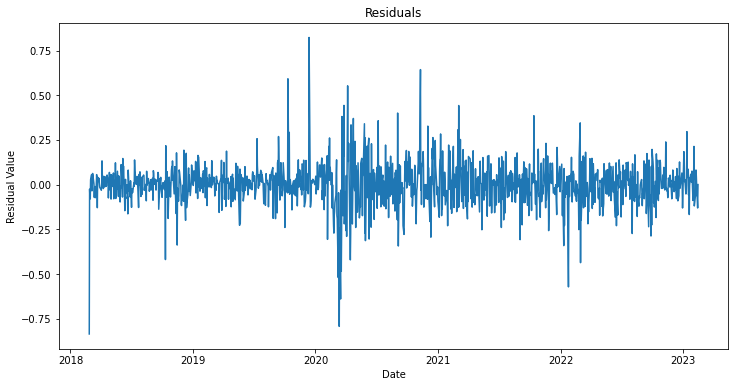

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1320.660, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1321.019, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1321.185, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1322.652, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1326.871, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1325.197, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1325.157, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1320.796, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1320.158, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1323.645, Time=1.77 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1328.858, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1323.176, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1323.011, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1327.185, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

                               SARIMAX Results                                
Dep. Variable:                  EDV.L   No. Observations:                 1255
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 667.429
Date:                Mon, 30 Oct 2023   AIC                          -1328.858
Time:                        17:06:53   BIC                          -1313.456
Sample:                             0   HQIC                         -1323.069
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7485      0.114      6.543      0.000       0.524       0.973
ma.L1         -0.8085      0.103     -7.865      0.000      -1.010      -0.607
sigma2         0.0202      0.000    160.224      0.0

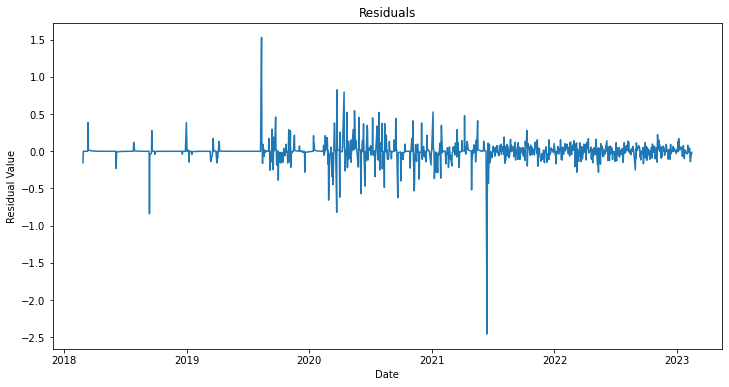

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1703.684, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1702.747, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1702.688, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1705.468, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1699.726, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.196 seconds
                               SARIMAX Results                                
Dep. Variable:                 ABDN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 853.734
Date:                Mon, 30 Oct 2023   AIC                          -1705.468
Time:                        17:06:55   BIC                          -1700.334
Sample:                             0   HQIC                         -1703.538
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

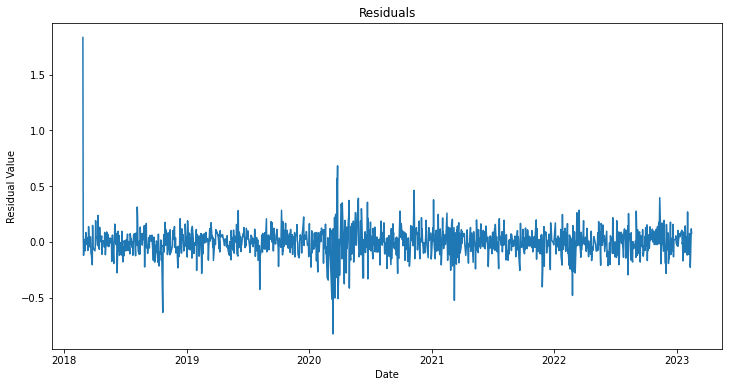

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1504.057, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1502.161, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1502.157, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1506.003, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1500.159, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.190 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 BLND.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 754.001
Date:                Mon, 30 Oct 2023   AIC                          -1506.003
Time:                        17:06:57   BIC                          -1500.869
Sample:                             0   HQIC                         -1504.073
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0176      0.000     52.367      0.000       0.017       0.018
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              2405.24
Prob(Q):                              0.75   Pr

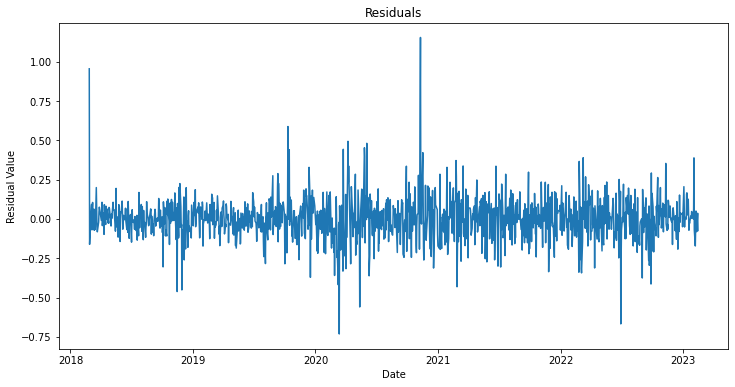

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1913.995, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1912.906, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1912.954, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1915.911, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1911.922, Time=0.94 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.700 seconds
                               SARIMAX Results                                
Dep. Variable:                 JMAT.L   No. Observations:                 1250
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 958.956
Date:                Mon, 30 Oct 2023   AIC                          -1915.911
Time:                        17:06:59   BIC                          -1910.781
Sample:                             0   HQIC                         -1913.982
                               - 1250                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


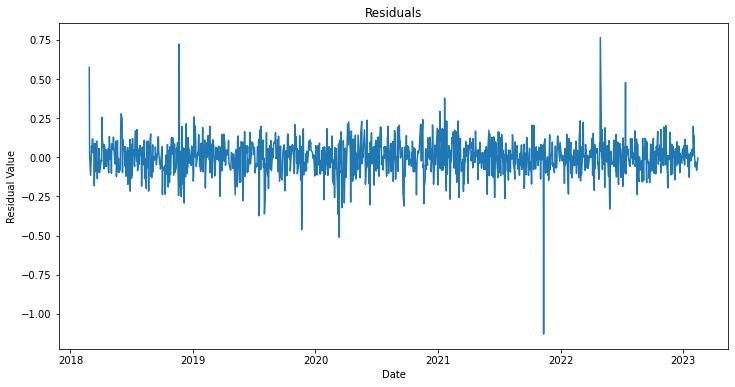

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2915.203, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2914.899, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2915.122, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2917.188, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2915.587, Time=1.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.572 seconds
                               SARIMAX Results                                
Dep. Variable:                  HSX.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1459.594
Date:                Mon, 30 Oct 2023   AIC                          -2917.188
Time:                        17:07:02   BIC                          -2912.054
Sample:                             0   HQIC                         -2915.258
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


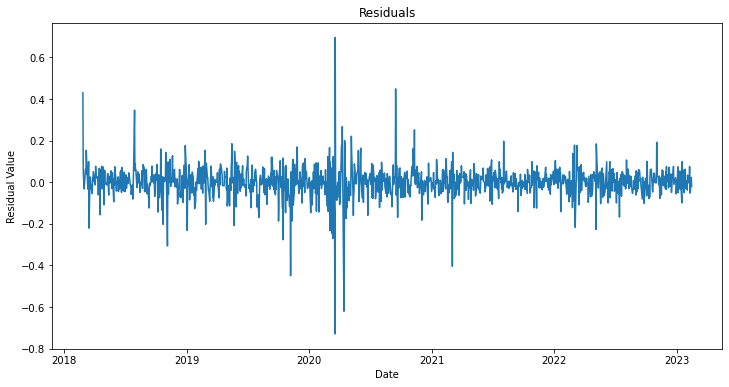

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1663.905, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1670.695, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1670.001, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1665.659, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1670.333, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1669.430, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1669.461, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1672.490, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1672.144, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1671.234, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1671.790, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1671.270, Time=0.34 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.567 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


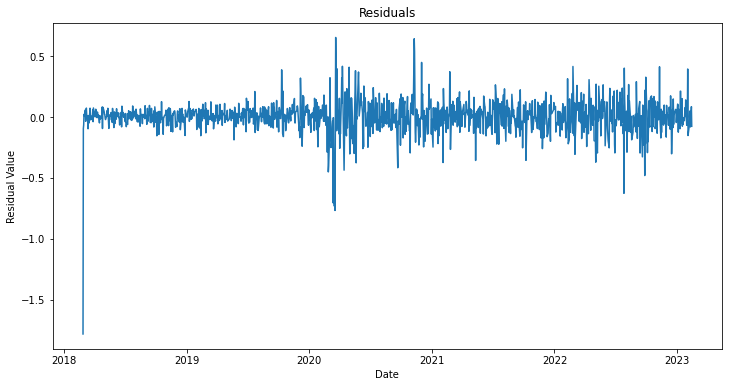

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3125.334, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3124.818, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3124.760, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3126.636, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3123.439, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.743 seconds
                               SARIMAX Results                                
Dep. Variable:                 FRAS.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1564.318
Date:                Mon, 30 Oct 2023   AIC                          -3126.636
Time:                        17:07:08   BIC                          -3121.502
Sample:                             0   HQIC                         -3124.707
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

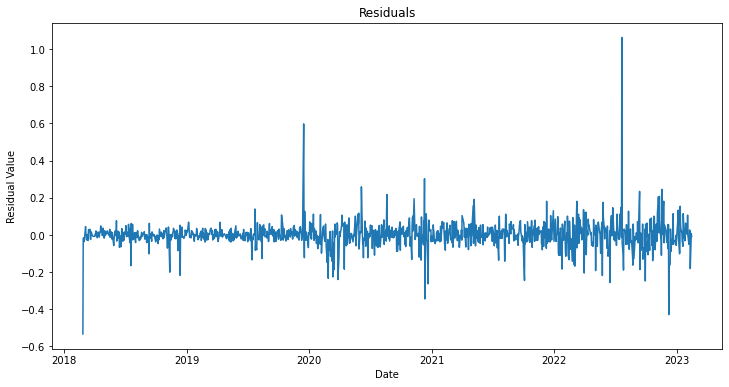

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3917.598, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3916.978, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3916.855, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3917.430, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3914.695, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.961 seconds
                               SARIMAX Results                                
Dep. Variable:                  CCL.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1959.715
Date:                Mon, 30 Oct 2023   AIC                          -3917.430
Time:                        17:07:11   BIC                          -3912.296
Sample:                             0   HQIC                         -3915.501
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


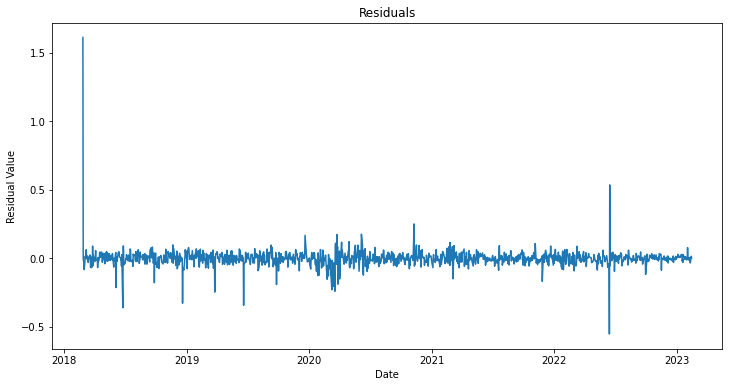

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3321.214, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3319.501, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3319.461, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3322.684, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3320.193, Time=0.98 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.916 seconds
                               SARIMAX Results                                
Dep. Variable:                 INVP.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1662.342
Date:                Mon, 30 Oct 2023   AIC                          -3322.684
Time:                        17:07:13   BIC                          -3317.550
Sample:                             0   HQIC                         -3320.754
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


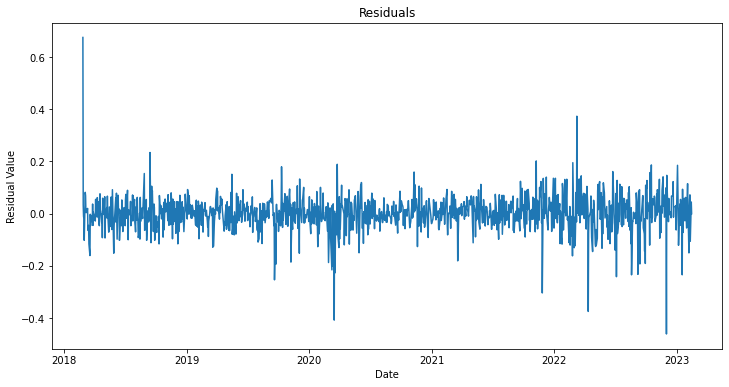

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2625.782, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2624.022, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2623.997, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2627.561, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2624.499, Time=0.81 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.844 seconds
                               SARIMAX Results                                
Dep. Variable:                  ICP.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1314.780
Date:                Mon, 30 Oct 2023   AIC                          -2627.561
Time:                        17:07:16   BIC                          -2622.427
Sample:                             0   HQIC                         -2625.631
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


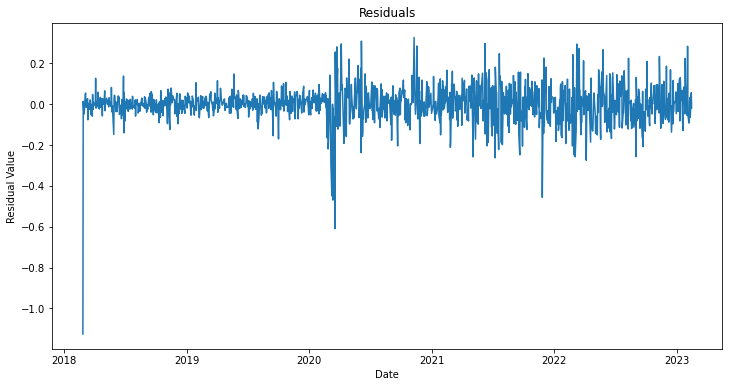

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2996.779, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2995.083, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2995.081, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2998.358, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2993.074, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.665 seconds
                               SARIMAX Results                                
Dep. Variable:                  IMI.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1500.179
Date:                Mon, 30 Oct 2023   AIC                          -2998.358
Time:                        17:07:18   BIC                          -2993.224
Sample:                             0   HQIC                         -2996.428
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


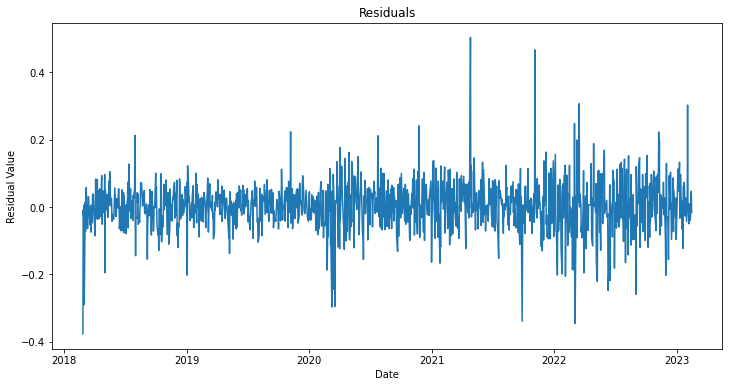

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2821.233, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2822.619, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2822.279, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2822.664, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2821.730, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.435 seconds
                               SARIMAX Results                                
Dep. Variable:                 HWDN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1412.332
Date:                Mon, 30 Oct 2023   AIC                          -2822.664
Time:                        17:07:20   BIC                          -2817.530
Sample:                             0   HQIC                         -2820.734
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


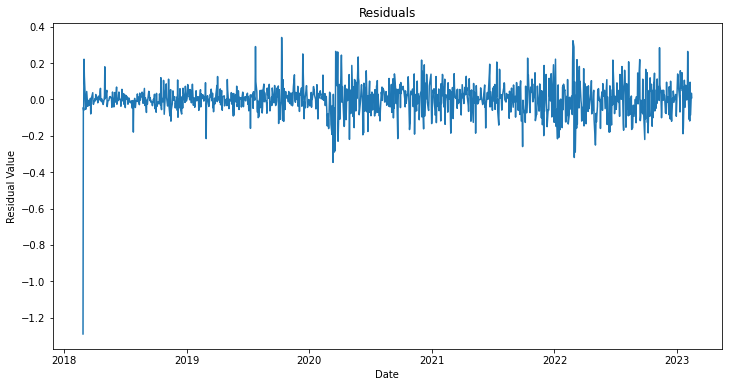

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2456.236, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2455.843, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2455.930, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2457.710, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2454.339, Time=0.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.177 seconds
                               SARIMAX Results                                
Dep. Variable:                  HIK.L   No. Observations:                 1254
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1229.855
Date:                Mon, 30 Oct 2023   AIC                          -2457.710
Time:                        17:07:22   BIC                          -2452.577
Sample:                             0   HQIC                         -2455.781
                               - 1254                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


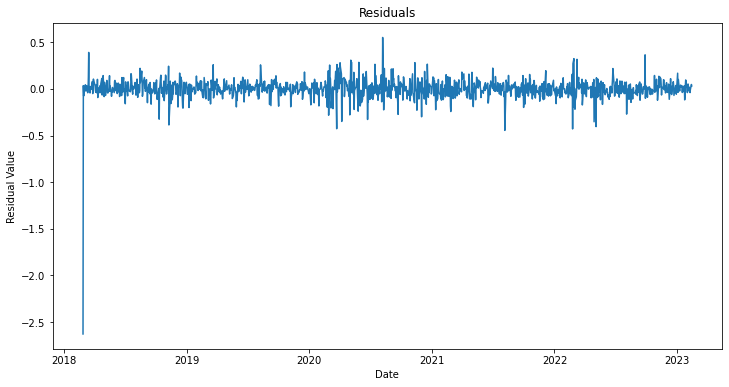

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-306.437, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-517.973, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-585.533, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-308.342, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-584.132, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-584.094, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-582.296, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-586.997, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-585.568, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-585.532, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-519.746, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-583.718, Time=0.81 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.303 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


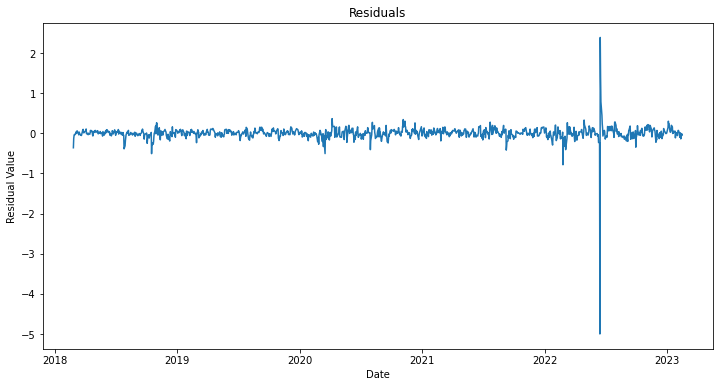

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2933.544, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2935.793, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2935.313, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2934.438, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2938.526, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2936.847, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2936.694, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2936.046, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2935.194, Time=1.38 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2939.665, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2936.812, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2937.959, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2937.821, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2937.210, Time=0.38 sec
 ARIMA(3,1,1)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  EZJ.L   No. Observations:                 1254
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1472.832
Date:                Mon, 30 Oct 2023   AIC                          -2939.665
Time:                        17:07:34   BIC                          -2924.265
Sample:                             0   HQIC                         -2933.876
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0554      0.026      2.153      0.031       0.005       0.106
ar.L2          0.0622      0.020      3.159      0.002       0.024       0.101
sigma2         0.0056   9.74e-05     57.287      0.0

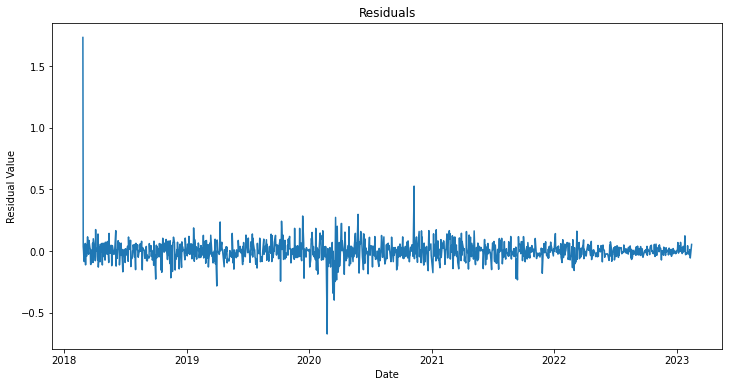

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-750.720, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-963.923, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1007.356, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-752.696, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1005.427, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1005.419, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1003.635, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1009.259, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1007.332, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1007.323, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-965.871, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1005.540, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.824 seconds
                               SARIMAX Results                                
D

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


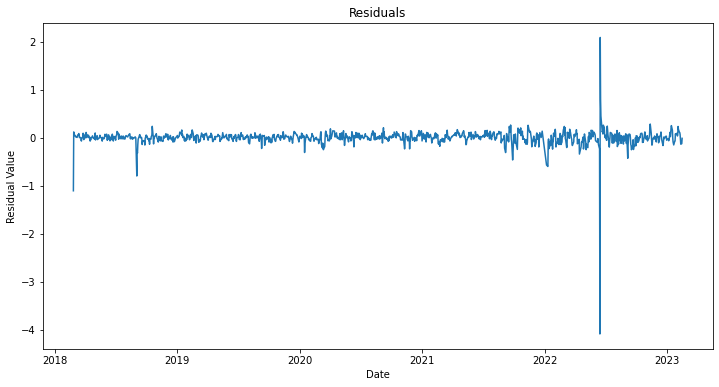

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2199.393, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2197.393, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2197.393, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2201.093, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2195.685, Time=0.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.273 seconds
                               SARIMAX Results                                
Dep. Variable:                  ITV.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1101.546
Date:                Mon, 30 Oct 2023   AIC                          -2201.093
Time:                        17:07:40   BIC                          -2195.959
Sample:                             0   HQIC                         -2199.163
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


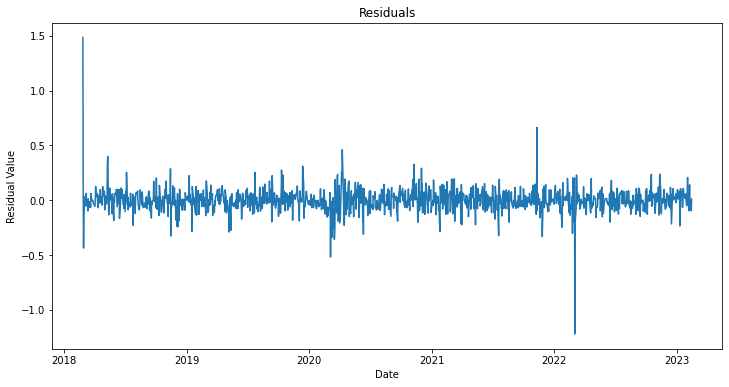

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3279.569, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3278.457, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3278.437, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3280.176, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3276.420, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.339 seconds
                               SARIMAX Results                                
Dep. Variable:                 DPLM.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1641.088
Date:                Mon, 30 Oct 2023   AIC                          -3280.176
Time:                        17:07:42   BIC                          -3275.042
Sample:                             0   HQIC                         -3278.246
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


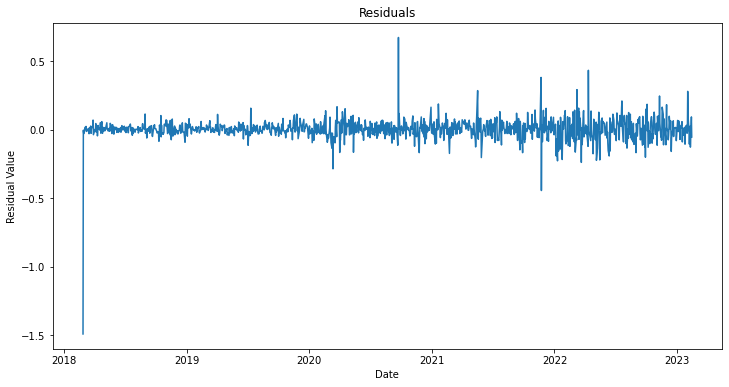

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2626.427, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2629.594, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2629.661, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2628.007, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2627.724, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2627.705, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2627.833, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2631.180, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2629.234, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2629.218, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2631.118, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2629.343, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.003 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


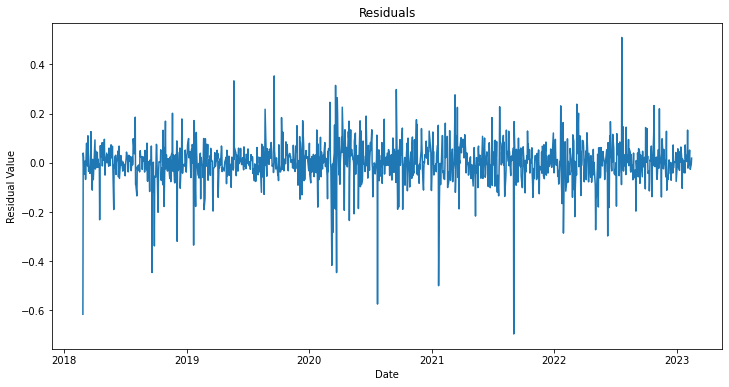

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2447.594, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2451.933, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2451.757, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2449.326, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2450.146, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2450.258, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2448.127, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2453.622, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2451.844, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2451.956, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2453.444, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2449.825, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.331 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


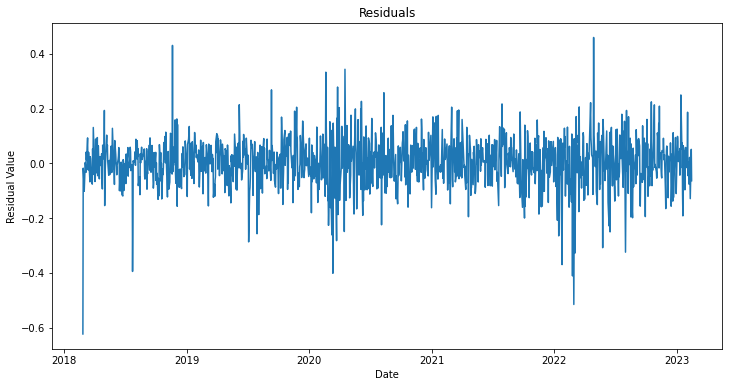

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1604.774, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1606.516, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1606.332, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1605.889, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1605.273, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1605.081, Time=0.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1603.272, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1607.530, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1606.333, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1606.114, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1607.346, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1604.333, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.931 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


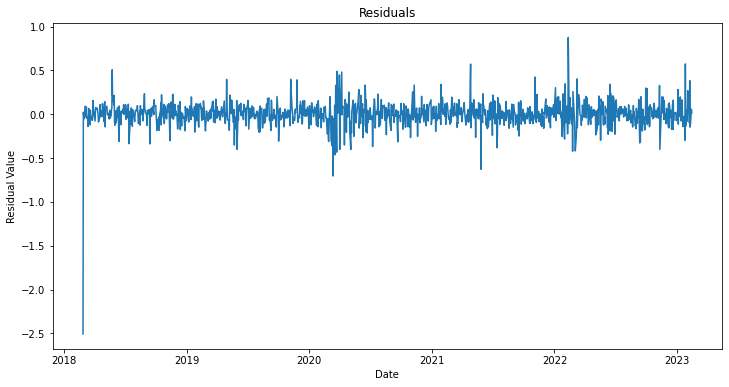

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3154.474, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3156.380, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3156.273, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3155.380, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3154.545, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3154.456, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3152.562, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3157.159, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3155.353, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3155.242, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3157.048, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3153.373, Time=0.39 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.238 seconds
                               SARIMAX Results                              

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


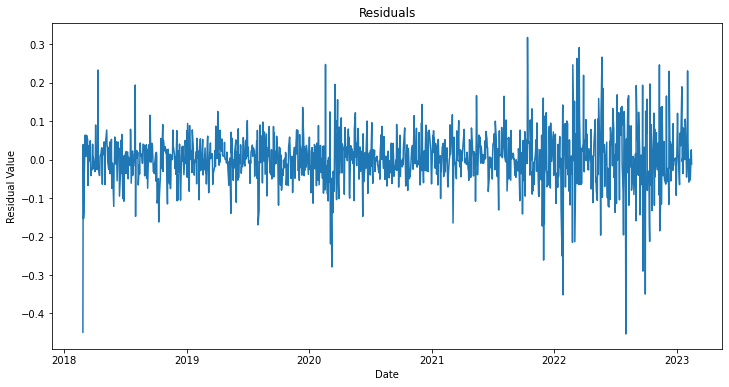

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4295.202, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4298.250, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4298.367, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4293.852, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4296.512, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4296.487, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4294.480, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4297.415, Time=0.50 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.468 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

                               SARIMAX Results                                
Dep. Variable:                  TUI.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2150.707
Date:                Mon, 30 Oct 2023   AIC                          -4297.415
Time:                        17:08:05   BIC                          -4287.146
Sample:                             0   HQIC                         -4293.555
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0668      0.020      3.393      0.001       0.028       0.105
sigma2         0.0019   2.45e-05     77.478      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.01   Jarque-

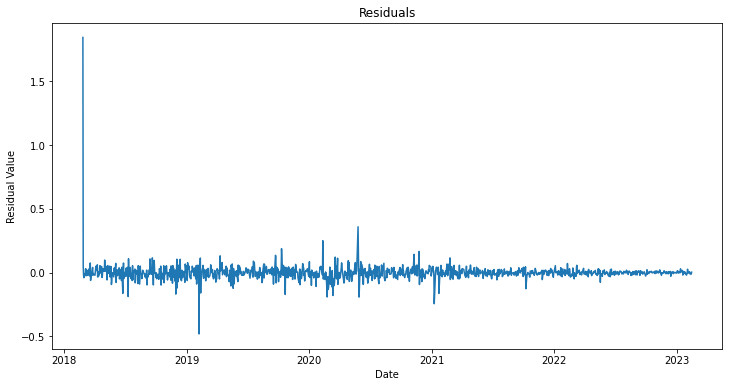

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2155.127, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2324.874, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2347.699, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2156.639, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2346.155, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2346.148, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2343.776, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2348.082, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2346.596, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2346.592, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2325.830, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2344.186, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.542 seconds


/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  GAW.L   No. Observations:                 1254
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1176.041
Date:                Mon, 30 Oct 2023   AIC                          -2348.082
Time:                        17:08:09   BIC                          -2337.815
Sample:                             0   HQIC                         -2344.223
                               - 1254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4004      0.003   -125.469      0.000      -0.407      -0.394
sigma2         0.0090   3.15e-05    284.639      0.000       0.009       0.009
Ljung-Box (L1) (Q):                   0.12   Jarque-

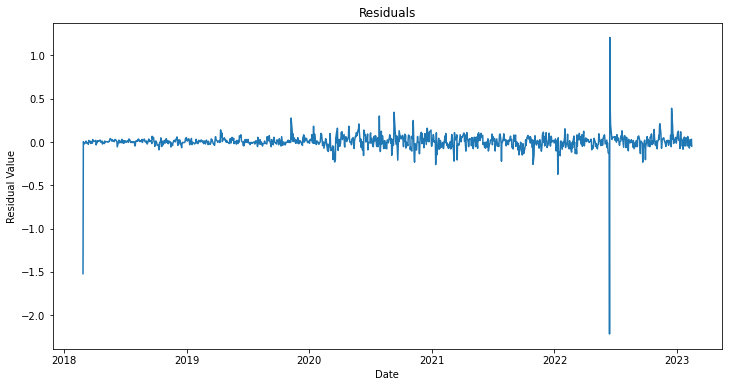

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2859.230, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2859.429, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2859.498, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2860.796, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2857.540, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.755 seconds
                               SARIMAX Results                                
Dep. Variable:                  MKS.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1431.398
Date:                Mon, 30 Oct 2023   AIC                          -2860.796
Time:                        17:08:11   BIC                          -2855.662
Sample:                             0   HQIC                         -2858.866
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


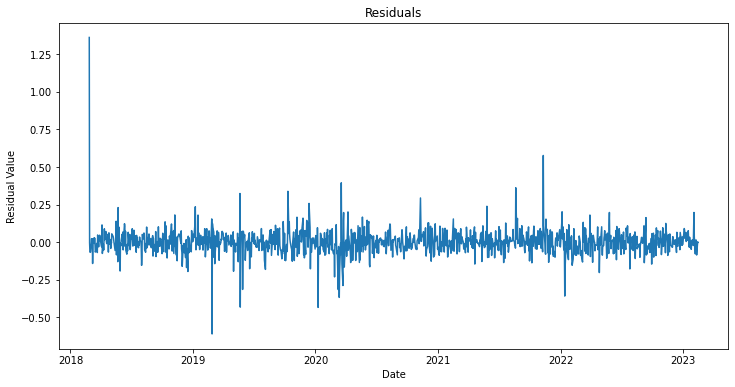

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1516.151, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1514.224, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1514.214, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1518.150, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1513.705, Time=0.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.554 seconds
                               SARIMAX Results                                
Dep. Variable:                  DLN.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 760.075
Date:                Mon, 30 Oct 2023   AIC                          -1518.150
Time:                        17:08:14   BIC                          -1513.016
Sample:                             0   HQIC                         -1516.220
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


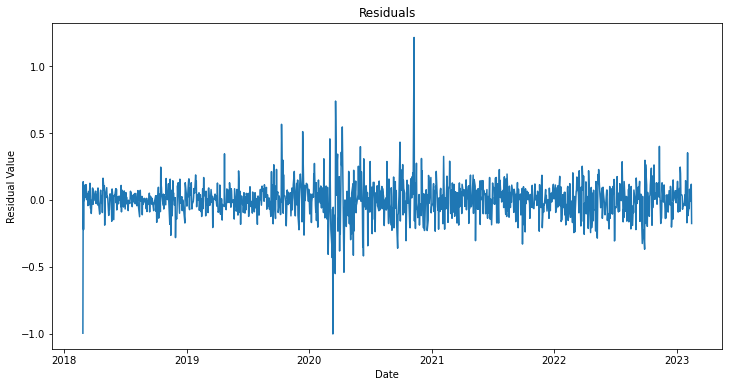

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1495.908, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1494.354, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1494.386, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1497.872, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1496.408, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.035 seconds
                               SARIMAX Results                                
Dep. Variable:                  RSW.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 749.936
Date:                Mon, 30 Oct 2023   AIC                          -1497.872
Time:                        17:08:15   BIC                          -1492.738
Sample:                             0   HQIC                         -1495.942
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


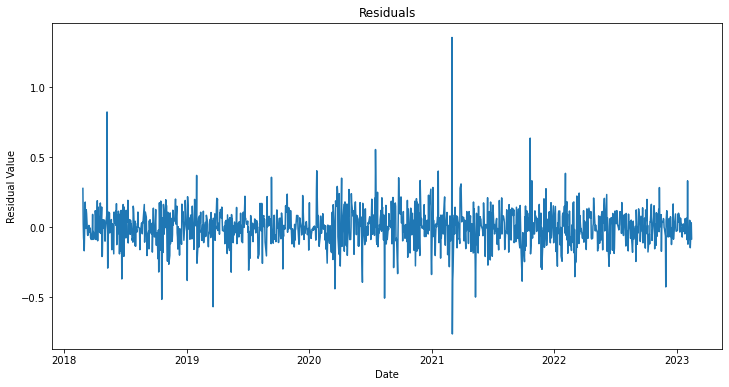

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-458.480, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-700.252, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-796.791, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-460.460, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-796.121, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-795.979, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-793.108, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-798.634, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-797.948, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-797.809, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-702.203, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-794.948, Time=0.61 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.156 seconds
                               SARIMAX Results                                
Dep. Vari

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


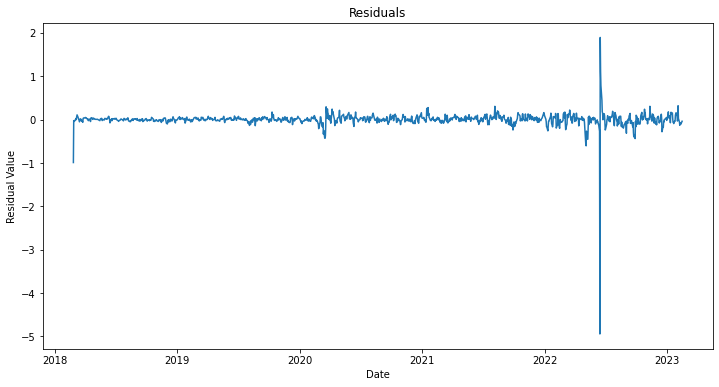

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=611.596, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=417.307, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=365.916, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=609.622, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=366.275, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=366.596, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=366.833, Time=1.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=364.035, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=364.409, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=364.727, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=415.365, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=364.983, Time=0.43 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.729 seconds
                               SARIMAX Results                                
Dep. Variable:       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


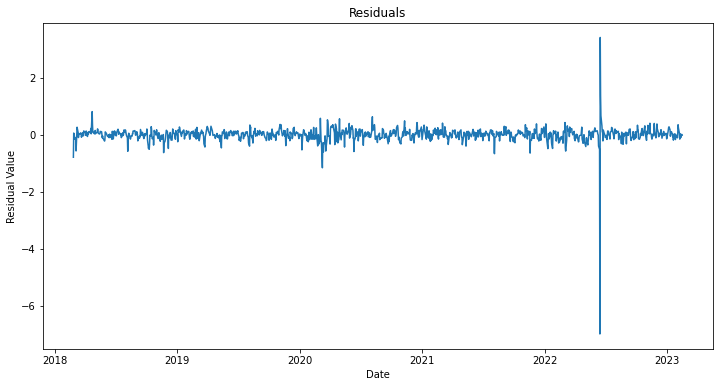

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2907.214, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2905.754, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2905.683, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2908.182, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2906.214, Time=1.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.034 seconds
                               SARIMAX Results                                
Dep. Variable:                  GRG.L   No. Observations:                 1255
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1455.091
Date:                Mon, 30 Oct 2023   AIC                          -2908.182
Time:                        17:08:27   BIC                          -2903.048
Sample:                             0   HQIC                         -2906.253
                               - 1255                                  

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


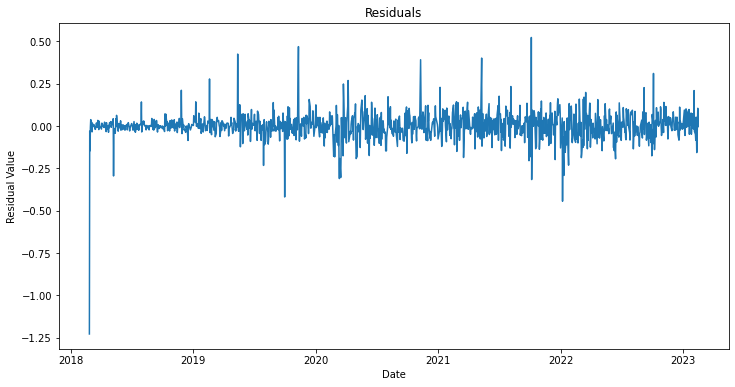

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1931.751, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1931.023, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1930.842, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1933.749, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1942.580, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1943.161, Time=1.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1937.807, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1941.361, Time=1.92 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1941.252, Time=1.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1943.068, Time=4.42 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1938.206, Time=0.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1939.459, Time=2.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1945.160, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1944.579, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VTY.L   No. Observations:                 1255
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 976.580
Date:                Mon, 30 Oct 2023   AIC                          -1945.160
Time:                        17:08:46   BIC                          -1924.624
Sample:                             0   HQIC                         -1937.441
                               - 1255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7681      0.085      9.040      0.000       0.602       0.935
ar.L2          0.0521      0.026      2.037      0.042       0.002       0.102
ma.L1         -0.7483      0.081     -9.201      0.0

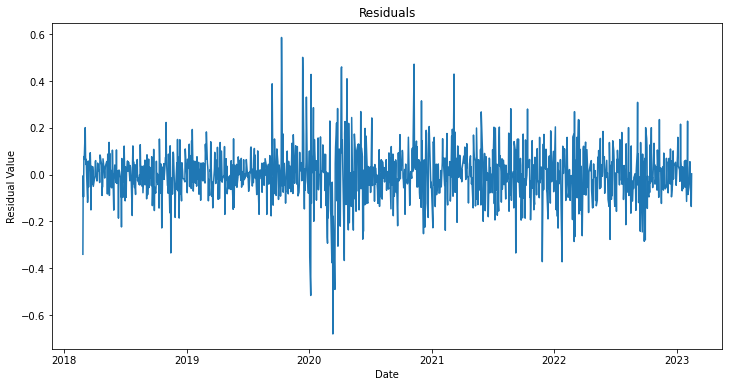

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
look_forward = 3
dict_df = get_ARIMA_PRED(df_standardised, look_forward)

In [16]:
dict_df_T = dict_df.T
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction
BDEV.L,0.0,0.0,1.0,-0.422818
EDV.L,1.0,1.0,1.0,-0.583302
ABDN.L,0.0,0.0,1.0,-0.183918
BLND.L,0.0,0.0,1.0,-0.137765
JMAT.L,0.0,0.0,1.0,-0.575116
HSX.L,0.0,0.0,1.0,0.104393
UTG.L,1.0,0.0,1.0,0.398995
FRAS.L,0.0,0.0,1.0,1.522187
CCL.L,0.0,0.0,1.0,-1.029902
INVP.L,0.0,0.0,1.0,2.332163


In [17]:
###############################


#PRODUCE NAIVE PREDICTION
naive_predictions = []
for column in df_standardised.columns:
    naive_predictions.append(df_standardised[column].iloc[-4])
dict_df_T["naive_prediction"] = naive_predictions


In [18]:
#verifying that the naive prediction is identical with the actual price.iloc[-4]

df_standardised.iloc[-4] == dict_df_T["naive_prediction"]

Ticker_Symbol
BDEV.L    True
EDV.L     True
ABDN.L    True
BLND.L    True
JMAT.L    True
HSX.L     True
UTG.L     True
FRAS.L    True
CCL.L     True
INVP.L    True
ICP.L     True
IMI.L     True
HWDN.L    True
HIK.L     True
INCH.L    True
EZJ.L     True
DPH.L     True
ITV.L     True
DPLM.L    True
IGG.L     True
SXS.L     True
TATE.L    True
EMG.L     True
TUI.L     True
GAW.L     True
MKS.L     True
DLN.L     True
RSW.L     True
BBOX.L    True
ROR.L     True
GRG.L     True
VTY.L     True
dtype: bool

In [19]:
dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]

BDEV.L     True
EDV.L     False
ABDN.L     True
BLND.L     True
JMAT.L     True
HSX.L      True
UTG.L     False
FRAS.L     True
CCL.L      True
INVP.L     True
ICP.L      True
IMI.L      True
HWDN.L     True
HIK.L      True
INCH.L    False
EZJ.L     False
DPH.L     False
ITV.L      True
DPLM.L     True
IGG.L     False
SXS.L     False
TATE.L    False
EMG.L     False
TUI.L     False
GAW.L     False
MKS.L      True
DLN.L      True
RSW.L      True
BBOX.L    False
ROR.L     False
GRG.L      True
VTY.L     False
dtype: bool

In [20]:
(dict_df_T["ARIMA_prediction"] == dict_df_T["naive_prediction"]).value_counts()

True     18
False    14
Name: count, dtype: int64

In [21]:
param_df = dict_df_T[dict_df_T["ARIMA_prediction"] != dict_df_T["naive_prediction"]]
param_df

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction
EDV.L,1.0,1.0,1.0,-0.583302,-0.600965
UTG.L,1.0,0.0,1.0,0.398995,0.405417
INCH.L,0.0,1.0,1.0,1.989280,1.969261
EZJ.L,2.0,0.0,1.0,-1.050793,-1.058532
DPH.L,0.0,1.0,1.0,-0.113193,-0.120133
IGG.L,0.0,1.0,1.0,1.329536,1.330739
SXS.L,1.0,0.0,1.0,1.049745,1.045269
TATE.L,1.0,0.0,1.0,1.740216,1.740762
EMG.L,1.0,0.0,1.0,2.096758,2.096082
TUI.L,0.0,1.0,1.0,-0.984189,-0.984418


In [22]:
#create a new dataframe for comparison of analysis

comparision_df = pd.DataFrame(index = param_df.index)

In [23]:
#file["Actual Price"].index = dict_df_T.index.to_list()
comparision_df["ARIMA_prediction"]=param_df["ARIMA_prediction"]
comparision_df["naive_prediction"]=param_df["naive_prediction"]

In [24]:
comparision_df["Actual Price, y"] = actual_price_df.loc[comparision_df.index].values 


In [25]:
comparision_df["SE_ARIMA"] =\
(
    np.square(comparision_df["ARIMA_prediction"].values - comparision_df["Actual Price, y"].values) 
)

comparision_df["SE_naive"] =\
(
    np.square(comparision_df["naive_prediction"].values - actual_price_df["actual_price"].loc[param_df.index].values)
)
comparision_df

,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
EDV.L,-0.583302,-0.600965,-0.823669,0.057776,0.049597
UTG.L,0.398995,0.405417,0.271792,0.016181,0.017856
INCH.L,1.989280,1.969261,1.974346,0.000223,0.000026
EZJ.L,-1.050793,-1.058532,-1.046627,0.000017,0.000142
DPH.L,-0.113193,-0.120133,-0.382770,0.072672,0.068978
IGG.L,1.329536,1.330739,1.307421,0.000489,0.000544
SXS.L,1.049745,1.045269,1.696508,0.418303,0.424112
TATE.L,1.740216,1.740762,1.949175,0.043664,0.043436
EMG.L,2.096758,2.096082,1.841547,0.065132,0.064788
TUI.L,-0.984189,-0.984418,-1.012759,0.000816,0.000803


In [26]:
dict_df_T["Actual Price, y"] = actual_price_df.loc[dict_df_T.index].values


In [27]:
dict_df_T["SE_ARIMA"] =\
(
    np.square(dict_df_T["ARIMA_prediction"].values - dict_df_T["Actual Price, y"].values) 
)

dict_df_T["SE_naive"] =\
(
    np.square(dict_df_T["naive_prediction"].values - dict_df_T["Actual Price, y"].values)
)
dict_df_T

,optimal_p,optimal_q,optimal_d,ARIMA_prediction,naive_prediction,"Actual Price, y",SE_ARIMA,SE_naive
BDEV.L,0.0,0.0,1.0,-0.422818,-0.422818,-0.380270,0.001810,0.001810
EDV.L,1.0,1.0,1.0,-0.583302,-0.600965,-0.823669,0.057776,0.049597
ABDN.L,0.0,0.0,1.0,-0.183918,-0.183918,-0.199179,0.000233,0.000233
BLND.L,0.0,0.0,1.0,-0.137765,-0.137765,-0.159263,0.000462,0.000462
JMAT.L,0.0,0.0,1.0,-0.575116,-0.575116,-0.713244,0.019079,0.019079
HSX.L,0.0,0.0,1.0,0.104393,0.104393,0.191023,0.007505,0.007505
UTG.L,1.0,0.0,1.0,0.398995,0.405417,0.271792,0.016181,0.017856
FRAS.L,0.0,0.0,1.0,1.522187,1.522187,1.745660,0.049940,0.049940
CCL.L,0.0,0.0,1.0,-1.029902,-1.029902,-1.050520,0.000425,0.000425
INVP.L,0.0,0.0,1.0,2.332163,2.332163,2.246348,0.007364,0.007364


In [28]:
#market share extraction. market share on rank date strictly

tickers = symbols_short

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )


result_ = extract_sp(tickers,start="2023-02-27", end="2023-02-28")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df_strict =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='last')

)

market_share_df_strict

,Company,Date,Market Share
15,HWDN.L,2023-03-01 00:00:00+00:00,558313984
14,IMI.L,2023-03-01 00:00:00+00:00,263152000
8,FRAS.L,2023-03-01 00:00:00+00:00,476830016
4,HSX.L,2023-03-01 00:00:00+00:00,347761984
24,ITV.L,2023-02-28 00:00:00+00:00,4025410048
32,TUI.L,2023-02-28 00:00:00+00:00,178520992
33,GAW.L,2023-02-28 00:00:00+00:00,32912800
34,DLN.L,2023-02-28 00:00:00+00:00,112291000
26,DPLM.L,2023-02-28 00:00:00+00:00,124680000
35,BBOX.L,2023-02-28 00:00:00+00:00,1868829952


In [29]:
### market share NEAR rank date

def extract_sp(stocks, start, end):
    def data(ticker):
        return(yf.Ticker(ticker).get_shares_full(start= start, end=end))
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )

#tickers = ['AAPL','MSFT']

tickers = symbols_short

result_ = extract_sp(tickers,start="2015-02-24", end="2023-02-28")
result_df = pd.DataFrame(result_, columns = ['Market Share'])
market_share_df =\
(
    result_df
    .reset_index()
    .sort_values(by='Date', ascending = False)
    .drop_duplicates(subset='Company', keep='first')

)

market_share_df

,Company,Date,Market Share
3737,IMI.L,2023-03-01 00:00:00+00:00,263152000
8044,EMG.L,2023-03-01 00:00:00+00:00,1239459968
5316,EZJ.L,2023-03-01 00:00:00+00:00,766571008
5856,ITV.L,2023-03-01 00:00:00+00:00,4085519872
2010,UTG.L,2023-03-01 00:00:00+00:00,401104000
5061,INCH.L,2023-03-01 00:00:00+00:00,413007008
6090,DPLM.L,2023-03-01 00:00:00+00:00,125934000
2284,FRAS.L,2023-03-01 00:00:00+00:00,476830016
5635,DPH.L,2023-03-01 00:00:00+00:00,117340000
2800,CCL.L,2023-03-01 00:00:00+00:00,1359549952


In [30]:
#checking for stock that doesnt have market share extracted


dict_df_T.index[~dict_df_T.index.isin(market_share_df["Company"].to_list())]

Index([], dtype='object')

In [31]:
market_share_df_ = market_share_df.set_index("Company")
ordered_market_share_df = market_share_df_.loc[dict_df_T.index]
ordered_market_share_df

,Date,Market Share
BDEV.L,2023-03-01 00:00:00+00:00,992454016
EDV.L,2023-02-25 00:00:00+00:00,247516000
ABDN.L,2023-02-24 00:00:00+00:00,2001890048
BLND.L,2023-02-28 00:00:00+00:00,927033024
JMAT.L,2023-02-28 00:00:00+00:00,183452992
HSX.L,2023-03-01 00:00:00+00:00,347761984
UTG.L,2023-03-01 00:00:00+00:00,401104000
FRAS.L,2023-03-01 00:00:00+00:00,476830016
CCL.L,2023-03-01 00:00:00+00:00,1359549952
INVP.L,2023-02-28 00:00:00+00:00,661660032


In [32]:
#un-normalise the actual_price
ticker_mean_df = pd.Series(ticker_mean_dict.values(), index = ticker_mean_dict.keys())
ticker_std_df = pd.Series(ticker_std_dict.values(), index = ticker_std_dict.keys())

dict_df_T["un-normalised_actual_mrkt_share"] = pd.Series((actual_price_df.values.flatten() * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_ARIMA_pred_mrkt_share"] = pd.Series((dict_df_T["ARIMA_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
dict_df_T["un-normalised_naive_pred_mrkt_share"] = pd.Series((dict_df_T["naive_prediction"].values * ticker_std_df.values) + ticker_mean_df.values, index = actual_price_df.index)
result = dict_df_T[["un-normalised_actual_mrkt_share", "un-normalised_ARIMA_pred_mrkt_share", "un-normalised_naive_pred_mrkt_share"]].mul(ordered_market_share_df["Market Share"], axis=0)
result.head(3)


,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share
BDEV.L,4.274303e+11,4.236892e+11,4.236892e+11
EDV.L,4.103597e+11,4.374509e+11,4.354601e+11
ABDN.L,3.949595e+11,3.960392e+11,3.960392e+11


In [33]:
symbols['Ticker'] = symbols['Ticker'].str.split(' ').str[0]
symbols['Ticker'] = symbols['Ticker'] + ".L"
symbols.head(3)

,Ticker,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BDEV.L,Barratt Developments PLC,0.220140,997.554257,453.7,4509702144,0081180,GB0000811801,FTSE100,BDEV.L
1,EDV.L,Endeavour Mining PLC,0.156651,181.340807,1776.0,4396320768,BL6K5J4,GB00BL6K5J42,FTSE100,EDV.L
3,ABDN.L,abrdn plc,0.207093,2034.237768,209.3,4189959936,BF8Q6K6,GB00BF8Q6K64,FTSE100,ABDN.L


In [34]:
#result is the prediction results
result2 = result.reset_index().rename(columns = {"index": "Ticker"})
merged = result2.merge(symbols, how='left', on='Ticker') #target universe is list before rank date
merged.head(3)

,Ticker,un-normalised_actual_mrkt_share,un-normalised_ARIMA_pred_mrkt_share,un-normalised_naive_pred_mrkt_share,Name,Weight,Shares,Price,Market Cap,SEDOL,ISIN,Index,Ticker_Symbol
0,BDEV.L,4.274303e+11,4.236892e+11,4.236892e+11,Barratt Developments PLC,0.220140,997.554257,453.7,4509702144,0081180,GB0000811801,FTSE100,BDEV.L
1,EDV.L,4.103597e+11,4.374509e+11,4.354601e+11,Endeavour Mining PLC,0.156651,181.340807,1776.0,4396320768,BL6K5J4,GB00BL6K5J42,FTSE100,EDV.L
2,ABDN.L,3.949595e+11,3.960392e+11,3.960392e+11,abrdn plc,0.207093,2034.237768,209.3,4189959936,BF8Q6K6,GB00BF8Q6K64,FTSE100,ABDN.L


In [35]:
## 90percentile decision module + confusion matrix 

In [36]:
post_rebalancing = pd.read_csv("ftse100_rebalancing_summary.csv")
post_rebalancing

,Ticker,Name,SEDOL\n,ISIN\n,Market Cap (Pre),Market Cap (Post),Post Date,FTSE100,FTSE250
0,CNA LN Equity,Centrica PLC,B033F22,GB00B033F229,NaN,4763841536,2022-06-20,1.0,-1.0
1,IDS LN Equity,International Distributions Services PLC,BDVZYZ7,GB00BDVZYZ77,2.999579e+09,NaN,2022-06-20,-1.0,1.0
2,ITV LN Equity,ITV PLC,3398649,GB0033986497,2.847575e+09,NaN,2022-06-20,-1.0,1.0
3,UTG LN Equity,UNITE Group PLC/The,0692861,GB0006928617,NaN,4340879872,2022-06-20,1.0,-1.0
4,ABDN LN Equity,abrdn plc,BF8Q6K6,GB00BF8Q6K64,3.273295e+09,NaN,2022-09-20,-1.0,1.0
5,AVST LN Equity,Avast Ltd,BDD85M8,GB00BDD85M81,7.253988e+09,NaN,2022-09-20,-1.0,NaN
6,CTEC LN Equity,ConvaTec Group PLC,BD3VFW7,GB00BD3VFW73,NaN,4430629888,2022-09-20,1.0,-1.0
7,FCIT LN Equity,F&C Investment Trust PLC,0346607,GB0003466074,NaN,--,2022-09-20,1.0,-1.0
8,FRAS LN Equity,Frasers Group PLC,B1QH8P2,GB00B1QH8P22,NaN,3710002176,2022-09-20,1.0,-1.0
9,HBR LN Equity,Harbour Energy PLC,BMBVGQ3,GB00BMBVGQ36,NaN,4109989632,2022-09-20,1.0,-1.0


In [37]:
#this is the decision module
def get_top10(merged_df, column):
    merged_df2 = merged_df.sort_values(by=column, ascending = False).reset_index(drop=True)
    ftse_250 = merged_df2[merged_df2["Index"] =='FTSE250']
    ftse_100 = merged_df2[merged_df2["Index"] =='FTSE100']

    # list of stocks that is going into FTSE100
    stocks_into_FTSE100 = ftse_250[ftse_250.index<ftse_100.index[0]]['Ticker'].to_list()

    # number of stocks that is going into FTSE100
    number_of_stocks = len(stocks_into_FTSE100)

    # list of stocks that is going out from FTSE100
    stocks_out_from_FTSE100 = ftse_100['Ticker'].tail(number_of_stocks).to_list()
    
    return stocks_into_FTSE100, stocks_out_from_FTSE100

stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive = get_top10(merged, "un-normalised_naive_pred_mrkt_share")
stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA = get_top10(merged, "un-normalised_ARIMA_pred_mrkt_share")

#non-existent date because there are no changes in the FTSE100 and 250 
date = "abc"

def confusion_matrix(stocks_into_FTSE100, stocks_out_from_FTSE100, date):
    post_rebalancing = pd.read_csv("ftse100_rebalancing_summary.csv")
    post_rebalancing_ = post_rebalancing[post_rebalancing["Post Date"] ==  date]
    
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'].str.split(' ').str[0]
    post_rebalancing_['Ticker'] = post_rebalancing_['Ticker'] + ".L"

    true_positive_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == -1.0]["Ticker"]
    )
    true_negative_100 =\
    (
        post_rebalancing_[post_rebalancing_["FTSE100"] == 1.0]["Ticker"]
    )
#     true_positive_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == 1.0]["Ticker"]
#     )
#     true_negative_250 =\
#     (
#         post_rebalancing_[post_rebalancing_["FTSE250"] == -1.0]["Ticker"]
#     )
    
    true_positive_count = 0
    true_negative_count = 0
    
    for outgoing in stocks_out_from_FTSE100:
        if true_positive_100.isin([outgoing]).any():
            true_positive_count+=1
    
    for incoming in stocks_into_FTSE100:
        if true_negative_100.isin([incoming]).any():
            true_negative_count+=1
            
    #reconfirm the top10 predicted
    going_up_length = len(stocks_into_FTSE100)

    retained_in_top10 = list(symbols["Ticker"].iloc[:10 - going_up_length].values)
    retained_in_top10.extend(stocks_into_FTSE100)

    #reconfirm the bottom 25 predicted
    coming_down_length = len(stocks_out_from_FTSE100)

    retained_in_bottom25 = list(symbols["Ticker"].iloc[(10 + coming_down_length):].values)
    retained_in_bottom25.extend(stocks_into_FTSE100)
    
    
#     true_positive = true_positive_count / len(retained_in_top10 + retained_in_bottom25)
#     false_positive = (len(retained_in_top10)-true_positive_count) / len(retained_in_top10 + retained_in_bottom25)
#     true_negative = true_negative_count / len(retained_in_top10 + retained_in_bottom25)
#     false_negative = (len(retained_in_bottom25)-true_negative_count) / len(retained_in_top10 + retained_in_bottom25)
    
    true_positive = true_positive_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_positive = (len(stocks_out_from_FTSE100) - true_positive_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    true_negative = true_negative_count / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    false_negative = (len(stocks_into_FTSE100) - true_negative_count) / (len(stocks_out_from_FTSE100) + len(stocks_into_FTSE100))
    
    #can return retained_in_top10 and retained_in_bottom25 to know the ordered prediction of top10&bottom25 if we want
    return true_positive, false_positive, true_negative, false_negative
    

In [38]:
true_positive_naive, false_positive_naive, true_negative_naive, false_negative_naive = confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive, date)
true_positive_ARIMA, false_positive_ARIMA, true_negative_ARIMA, false_negative_ARIMA = confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA, date)

In [39]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_naive, stocks_out_from_FTSE100_naive,date))

1.0

In [40]:
#logic check, must sum to 1
sum(confusion_matrix(stocks_into_FTSE100_ARIMA, stocks_out_from_FTSE100_ARIMA,date))

1.0

In [41]:
print("Percentage of true positive in naive model is {:.3f}%".format(true_positive_naive*100))
print("Percentage of true negative in naive model is {:.3f}%".format(true_negative_naive*100))
print("Percentage of false positive in naive model is {:.3f}%".format(false_positive_naive*100))
print("Percentage of false negative in naive model is {:.3f}%".format(false_negative_naive*100))

Percentage of true positive in naive model is 0.000%
Percentage of true negative in naive model is 0.000%
Percentage of false positive in naive model is 50.000%
Percentage of false negative in naive model is 50.000%


In [42]:
print("Percentage of true positive in ARIMA model is {:.3f}%".format(true_positive_ARIMA*100))
print("Percentage of true negative in ARIMA model is {:.3f}%".format(true_negative_ARIMA*100))
print("Percentage of false positive in ARIMA model is {:.3f}%".format(false_positive_ARIMA*100))
print("Percentage of false negative in ARIMA model is {:.3f}%".format(false_negative_ARIMA*100))

Percentage of true positive in ARIMA model is 0.000%
Percentage of true negative in ARIMA model is 0.000%
Percentage of false positive in ARIMA model is 50.000%
Percentage of false negative in ARIMA model is 50.000%


In [43]:
#param_df shows us the parameters that gave different ARIMA and Naive predictions

In [44]:
#same false positive between ARIMA and NAIVE.